### General description of the dataset

In [28]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('agaricus-lepiota.data', sep=',', header=None)
# Add column IDs
# I am lazy so I will just read them from a file
colnames = pd.read_csv('colnames.txt', header=None)
colID = ['target']
for i in colnames[0]:
    colID.append(i)

data.columns = colID
target_var = data['target']
data.drop('target', axis = 1, inplace=True)
y = LabelEncoder().fit_transform(target_var) # p == 1, e == 0
print(data.columns)
data.head()

Index(['cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')


,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


### Question to answer with the dataset

1. Is there a simple parameter that could be able to classify mushrooms?

2. Based on morphological data, which mushrooms parts (cap, gill, stalk, veil, rings, spores) is more informative for mushrooms classification (you can use LDA on single mushrooms parts)?

3. Does population and growth habitat is able to discriminate edible vs poisonous mushrooms (LDA together)?

4. Which will be the most important morphological descriptors for mushrooms classification (DecisionTree on morphological)?

### 1. Is there a simple parameter that could be able to classify mushrooms?

There are a couple of biological considerations that could drive us in the choice of a suitable parameter able to classify mushrooms:

* Wild animals (especially mammals) eats mushrooms and need to be able to safely identify poisonous mushrooms;

* Probably mushrooms that are poisonous for humans are as well poisonous for mammals in general;

* One of the most developed sense in wild mammals is smell, and they have less to no ability in discriminating morphological characteristics;

Based on these points I suggests that the odor of the mushrooms could be a good proxy, especially for wild animals, for identifying poisonous mushrooms.

#### 1.1) % of poisonous/edible mushrooms based on odor classes

        E    P
odor          
a     1.0  0.0
c     0.0  1.0
f     0.0  1.0
l     1.0  0.0
m     0.0  1.0


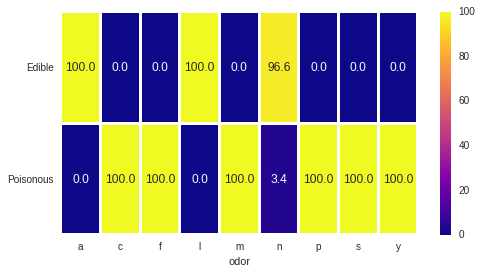

In [17]:
# create DF with odor data
odor = pd.DataFrame({'p':y, 'odor':data['odor']})
odor_poison = odor.groupby('odor').sum()
odor_poison_size = odor.groupby('odor').size()
odor_data = pd.DataFrame({'P': odor_poison['p']/odor_poison_size, 
                          'E':(odor_poison_size-odor_poison['p'])/odor_poison_size})
print(odor_data.head())
plt.figure(figsize=(8,4))
sns.set(style='whitegrid', context='notebook')
sns.heatmap(odor_data.T*100, fmt = '.1f', cmap = 'plasma', cbar = True, annot = True, 
            linewidth = 2, yticklabels=('Edible', 'Poisonous'))
plt.yticks(rotation=0)
plt.show()

Seems that odor could be a good parameters for classifying mushrooms

#### 1.2) Develop a simple logical model for mushrooms classification

             precision    recall  f1-score   support

     edible       0.97      1.00      0.99      4208
  poisonous       1.00      0.97      0.98      3916

avg / total       0.99      0.99      0.99      8124

Accuracy:  0.985228951256


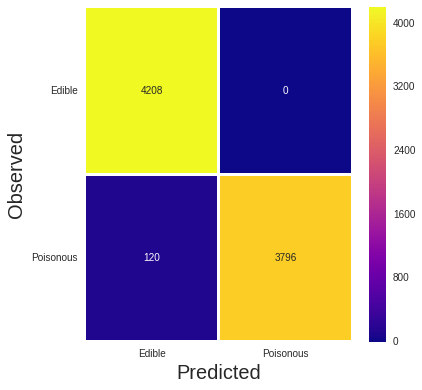

In [38]:
## create a small decision rule for categorical variables
def odor_decision_rule(odor_vars):
    non_poison = ['a', 'l', 'n']
    pred = ['e' if i in non_poison else 'p' for i in odor_vars]
    return LabelEncoder().fit_transform(pred)

X = data['odor'].values
pred = odor_decision_rule(X)
print(classification_report(y, pred, target_names = ['edible', 'poisonous']))
print('Accuracy: ', accuracy_score(y, pred))
plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix(y, pred),
           cmap = 'plasma', annot = True,
            fmt = '.0f', cbar = True,linewidth = 2, 
            yticklabels=('Edible', 'Poisonous'),
            xticklabels=('Edible', 'Poisonous')
           )
plt.yticks(rotation=0)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Observed', fontsize=20)
plt.show()

Despite the good predictive ability of this model, it would be more useful from a human perspective to develop a model able to classify mushrooms based on morphological parameters

### spore types

              E         P
spore                    
b      1.000000  0.000000
h      0.029412  0.970588
k      0.880342  0.119658
n      0.886179  0.113821
o      1.000000  0.000000
r      0.000000  1.000000
u      1.000000  0.000000
w      0.241206  0.758794
y      1.000000  0.000000


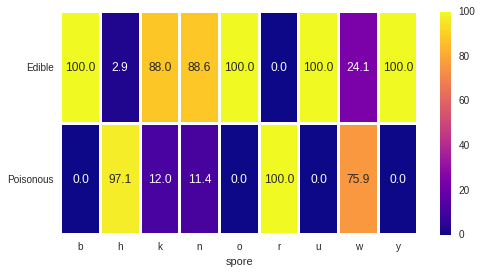

In [25]:
## Tryveil type
spore = pd.DataFrame({'p':y, 'spore':data['spore-print-color']})
spore_poison = hab.groupby('spore').sum()
spore_poison_size = hab.groupby('spore').size()
spore_data = pd.DataFrame({'P': spore_poison['p']/spore_poison_size, 
                          'E':(spore_poison_size-spore_poison['p'])/spore_poison_size})
print(spore_data)

plt.figure(figsize=(8,4))
sns.heatmap(spore_data.T*100, fmt = '.1f', cmap = 'plasma', cbar = True, annot = True, 
            linewidth = 2, yticklabels=('Edible', 'Poisonous'))
plt.yticks(rotation=0)
plt.show()

             precision    recall  f1-score   support

     edible       0.90      0.85      0.87       851
  poisonous       0.84      0.90      0.87       774

avg / total       0.87      0.87      0.87      1625

Accuracy:  0.872615384615


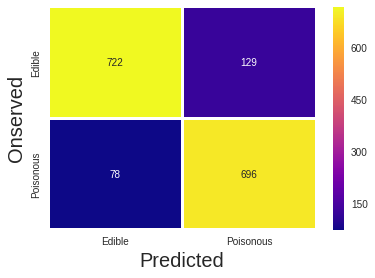

In [44]:
from sklearn.tree import DecisionTreeClassifier
    
X = pd.get_dummies(data['spore-print-color']).values


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.2, random_state=101)
tree = DecisionTreeClassifier(max_depth=20, random_state=101)

tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['edible', 'poisonous']))
print('Accuracy: ', accuracy_score(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),
           cmap = 'plasma', fmt = '.0f', annot=True,
           cbar=True, linewidth=2,
           yticklabels=('Edible', 'Poisonous'),
           xticklabels=("Edible", 'Poisonous'))
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Onserved', fontsize=20)
plt.show()

In [47]:
pd.get_dummies(data['spore-print-color']).head()

,b,h,k,n,o,r,u,w,y
0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0
